In [9]:
%reload_ext autoreload
%autoreload 2

In [31]:
from gpt3forchem.data import get_uspto_yield_data
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.input import create_reaction_yield_prompts

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.xtras import save_pickle
import time

In [11]:
data = get_uspto_yield_data()

/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/gpt3forchem/data.py:226: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(datadir, "USTPO_yields.csv"))


In [12]:
train_reaction_smiles, test_reaction_smiles = train_test_split(data['reaction_smiles'].unique(), train_size=0.8)
train_data = data[data['reaction_smiles'].isin(train_reaction_smiles)].sample(80_000)
test_data = data[data['reaction_smiles'].isin(test_reaction_smiles)].sample(5_000)

In [13]:
train_prompts = create_reaction_yield_prompts(train_data) 
test_prompts = create_reaction_yield_prompts(test_data)

In [14]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [15]:
fine_tune(train_filename, valid_filename)

Uploaded file from run_files/2022-11-08-16-41-26_train_prompts_uspto_yield_regression_79996.jsonl: file-JpE4QZfKy6bc8sCpMKmEbpCm
Uploaded file from run_files/2022-11-08-16-41-26_valid_prompts_uspto_yield_regression_5000.jsonl: file-5zTJuM3JGKjj8C0gtVRIKMil
Created fine-tune: ft-tZzCs8f7geM3c7hrRyXLzD0h
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-11-08 16:43:16] Created fine-tune: ft-tZzCs8f7geM3c7hrRyXLzD0h
[2022-11-08 16:43:54] Fine-tune costs $26.95
[2022-11-08 16:43:55] Fine-tune enqueued. Queue number: 0

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-tZzCs8f7geM3c7hrRyXLzD0h

 
Upload progress:   0%|          | 0.00/93.2M [00:00<?, ?it/s]
Upload progress: 100%|██████████| 93.2M/93.2M [00:00<00:00, 68.3Git/s]

Upload progress:   0%|          | 0.00/5.84M [00:00<?, ?it/s]
Upload progress: 100%|██████████| 5.84M/5.84M [00:00<00:00, 9.65Git/s]



In [25]:
test_prompts_filtered = []

for i, row in test_prompts.iterrows():
    if len(row['prompt']) < 1000:
        test_prompts_filtered.append(row)

In [26]:
len(test_prompts_filtered)

4465

In [28]:
test_prompts_filtered_frame = pd.DataFrame(test_prompts_filtered)

In [29]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-11-08-18-02-20', test_prompts_filtered_frame)

In [32]:
save_pickle('run_files/ada:ft-lsmoepfl-2022-11-08-18-02-20_completions.pkl', (completions, test_prompts_filtered_frame))

In [49]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])

In [36]:
true = test_prompts_filtered_frame['completion'].apply(lambda x: int(x.split('@@@')[0])).values

In [54]:
good_predictions = (predictions < 100) & (predictions > 0)
good_true = (true < 100) & (true > 0)

In [55]:
r2_score(true[good_predictions & good_true], predictions[good_predictions & good_true])

-0.034200796738945716

(0.0, 100.0)

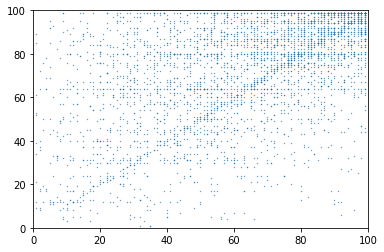

In [58]:
plt.scatter(true[good_predictions & good_true], predictions[good_predictions & good_true], s=.1)
plt.xlim(0, 100)
plt.ylim(0, 100)